In [15]:
from shell.datasets.datasets import get_dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from shell.utils.utils import seed_everything
import torch
import subprocess
import torch.nn as nn
import torch
import os
from omegaconf import DictConfig
from shell.datasets.datasets import get_dataset
from shell.utils.utils import seed_everything
from pprint import pprint
from shell.fleet.network import TopologyGenerator
from shell.models.cnn_soft_lifelong_dynamic import CNNSoftLLDynamic
from shell.models.cnn import CNN
from shell.models.mlp import MLP
from shell.models.mlp_soft_lifelong_dynamic import MLPSoftLLDynamic
from shell.learners.er_dynamic import CompositionalDynamicER
from shell.learners.er_nocomponents import NoComponentsER
from shell.utils.experiment_utils import eval_net
from shell.utils.experiment_utils import setup_experiment
from sklearn.manifold import TSNE
import logging
import seaborn as sns
import torchvision.transforms as transforms
logging.basicConfig(level=logging.INFO)


seed_everything(0)

In [16]:
data_cfg = {
    # "dataset_name": "mnist",
    # "dataset_name": "fashionmnist",
    "dataset_name": "cifar100",
    "num_tasks": 1,
    # "num_classes_per_task": 100,
    "num_classes_per_task": 2,
    "num_train_per_task": 128,
    # "labels": np.array([1, 2]),
    'remap_labels': True,
}


# data_cfg = {
#     "dataset_name": "cifar100",
#     "num_tasks": 1,
#     "num_classes_per_task": 2,
#     "num_train_per_task": 128,
#     "labels": np.array([1, 2]),
#     'remap_labels': True,
# }



# data_cfg = {
#     # "dataset_name": "mnist",
#     "dataset_name": "fashionmnist",
#     "num_tasks": 1,
#     "num_classes_per_task": 2,
#     "num_train_per_task": 128,
#     "labels": np.array([1, 2]),
#     'remap_labels': True,
# }



dataset = get_dataset(**data_cfg)

INFO:root:Class sequence: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]
INFO:root:task 0 :(128, 3, 32, 32)


In [17]:
"""
Define NetCls and AgentCls
"""

net_cfg = {
    'depth': 2,
    'layer_size': 64,
    'num_init_tasks': -1,
    'i_size': 28,
    'num_classes': 2,
    'num_tasks': 1,
}

agent_cfg = {
    'memory_size': 64,
    'use_contrastive': True,
    'dataset_name': data_cfg['dataset_name'],
}
net = MLP(**net_cfg)
agent = NoComponentsER(net, **agent_cfg)

In [18]:
agent.train_transform

Compose(
    RandomResizedCrop(size=(28, 28), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomApply(
    p=0.8
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.1, 0.1))
)
    RandomGrayscale(p=0.2)
)

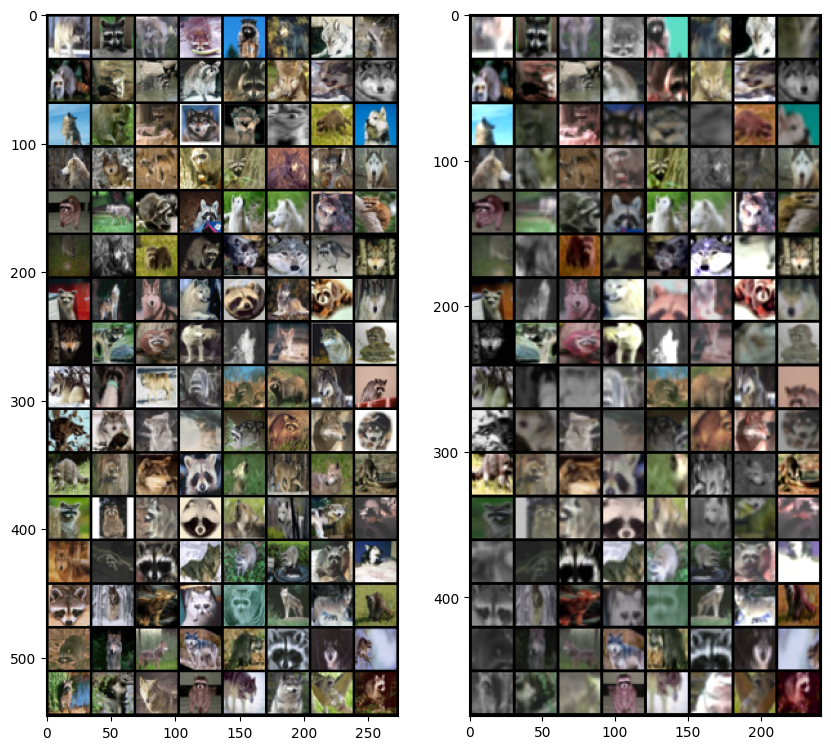

In [19]:
X = dataset.trainset[0].tensors[0]
Y = dataset.trainset[0].tensors[1]
X_a = agent.apply_transform(X)

img1 = make_grid(X, nrow=8)
img2 = make_grid(X_a, nrow=8)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))

plt.subplot(1, 2, 2)

plt.imshow(img2.permute(1, 2, 0));

In [ ]:
# task_id = 0
# trainloader = torch.utils.data.DataLoader(dataset.trainset[task_id],
#                                             batch_size=64,
#                                             shuffle=True,
#                                             num_workers=0,
#                                             pin_memory=True,
#                                             )
# testloaders = {task: torch.utils.data.DataLoader(testset,
#                                                          batch_size=128,
#                                                          shuffle=False,
#                                                          num_workers=0,
#                                                          pin_memory=True,
#                                                          ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}
# agent.train(trainloader, task_id=0, num_epochs=150, testloaders=testloaders,
#              train_mode='both')

In [ ]:
print(X.mean())
print(X_a.mean())

In [ ]:
print(X.shape) # (batch, channel, h, w)
# take mean along the channel dim, and return 3 numbers
r_mean, g_mean, b_mean = torch.mean(X[:, 0, :, :]), torch.mean(X[:, 1, :, :]), torch.mean(X[:, 2, :, :])
r_mean, g_mean, b_mean

In [ ]:
r_std, g_std, b_std = torch.std(X[:, 0, :, :]), torch.std(X[:, 1, :, :]), torch.std(X[:, 2, :, :])
r_std, g_std, b_std

In [ ]:
print(X_a.shape)
# take mean along the channel dim, and return 3 numbers
r_mean, g_mean, b_mean = torch.mean(X_a[:, 0, :, :]), torch.mean(X_a[:, 1, :, :]), torch.mean(X_a[:, 2, :, :])
r_mean, g_mean, b_mean

In [ ]:
r_std, g_std, b_std = torch.std(X_a[:, 0, :, :]), torch.std(X_a[:, 1, :, :]), torch.std(X_a[:, 2, :, :])
r_std, g_std, b_std

In [ ]:
mean = (0.5079, 0.4872, 0.4415)
std = (0.2676, 0.2567, 0.2765)
normalize = transforms.Normalize(mean=mean, std=std)

X_norm = normalize(X)

In [ ]:
r_mean, g_mean, b_mean = torch.mean(X_norm[:, 0, :, :]), torch.mean(X_norm[:, 1, :, :]), torch.mean(X_norm[:, 2, :, :])
r_mean, g_mean, b_mean

In [ ]:
r_std, g_std, b_std = torch.std(X_norm[:, 0, :, :]), torch.std(X_norm[:, 1, :, :]), torch.std(X_norm[:, 2, :, :])
r_std, g_std, b_std